# 任务2 数据清洗(2天)
每一步都要认真完成，附上代码，最终效果截图

## 缺失值分析及处理

* 缺失值出现的原因分析
* 采取合适的方式对缺失值进行填充

## 异常值分析及处理

* 根据测试集数据的分布处理训练集的数据分布

* 使用合适的方法找出异常值
* 对异常值进行处理

## 深度清洗

* 分析每一个communityName、city、region、plate的数据分布并对其进行数据清洗





# 缺失值处理

In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

In [2]:
#载入数据
data_train = pd.read_csv('./data/train_data.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('./data/test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)

## 主要思路分析  
1. **缺失值处理**  
缺失值的处理手段大体可以分为：删除、填充、映射到高维(当做类别处理)。 
此训练集上找到的缺失值只有特征pu和pv；
另外，根据特征nunique分布的分析，可以发现rentType存在"--"的情况，这也算是一种缺失值；  
rentType的"未知方式"和houseToward的"暂无数据"等，本质上也算是一种缺失值，但是对于这些缺失方式，我们可以把它当做是特殊的一类处理，而不需要去主动修改或填充值。  
  
将rentType的"--"转换成"未知方式"类别；  
pv/pu的缺失值用均值填充；  
buildYear存在"暂无信息"，将其用众数填充。  
  
  
2. **转换object类型数据**  
对类别型特征直接采用LabelEncoder的编码，转换成数值。 
  
  
3. **时间字段的处理**  
buildYear由于存在"暂无信息",所以需要主动将其转换int类型；
buildYear可以和当前年份做差，得到房子已经有多少年历史了。
tradeTime，将其分割成月和日。  
  
  
4. **删除无关字段**  
ID是唯一码，建模无用，所以直接删除；  
city只有一个SH值，也直接删除；  
tradeTime已经分割成年，月和日，删除原来字段

Text(0, 0.5, 'number of occurrences')

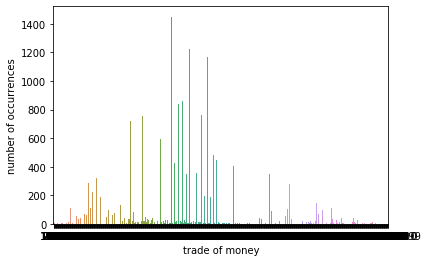

In [3]:
sns.countplot(data_train['tradeMoney'])
plt.xlabel("trade of money")
plt.ylabel("number of occurrences")

## 1. 缺失值处理 

### 1）填充pv和uv的空值

In [4]:
data_train['pv'].fillna(data_train['pv'].mean(), inplace=True)
data_train['uv'].fillna(data_train['uv'].mean(), inplace=True)
data_train['pv'] = data_train['pv'].astype('int')
data_train['uv'] = data_train['uv'].astype('int')

### 2)  对类别型特征做labelEncoder编码

In [5]:
columns = ['rentType','houseType', 'houseFloor', 'houseToward', 'houseDecoration','communityName','region', 'plate']

le = LabelEncoder()
for col in columns:
    data_train[col] = le.fit_transform(data_train[col])

### 3) 对特殊缺失值做处理

In [6]:
# 对rentType值是'--'转换成‘未知方式’
data_train['rentType'][data_train['rentType'] == '--'] = '未知方式'

# 对buildYear做处理
buildYearMean = pd.DataFrame(data_train[data_train['buildYear']!='暂无信息']['buildYear'].mode())
data_train.loc[data_train[data_train['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearMean.iloc[0,0]
data_train['buildYear'] = data_train['buildYear'].astype('int')

# 对交易时间做处理
def year(x):
    return int(x.split('/')[0])
def month(x):
    return int(x.split('/')[1])
def day(x):
    return int(x.split('/')[2])

data_train['year'] = data_train['tradeTime'].apply(lambda x: year(x))
data_train['month'] = data_train['tradeTime'].apply(lambda x: month(x))
data_train['day'] = data_train['tradeTime'].apply(lambda x: day(x))


In [7]:
from datetime import datetime

now = datetime.now()
current_year = int(now.strftime('%Y'))

# 增加一个房子年龄的字段
data_train['age'] = current_year - data_train['buildYear']
print(data_train['age'])

0        67
1        13
2        26
3        26
4        26
         ..
41435    11
41436    16
41437    20
41438    22
41439     5
Name: age, Length: 41440, dtype: int32


### 4) 去掉部分特征


In [9]:
# ID 无用，city值只有一个SH，tradeTime已经提炼了年月日，所以去掉这三个特征
data_train.drop(['ID','city','tradeTime'], axis=1, inplace=True)

In [10]:
data_train.isnull().sum()

area                  0
rentType              0
houseType             0
houseFloor            0
totalFloor            0
houseToward           0
houseDecoration       0
communityName         0
region                0
plate                 0
buildYear             0
saleSecHouseNum       0
subwayStationNum      0
busStationNum         0
interSchoolNum        0
schoolNum             0
privateSchoolNum      0
hospitalNum           0
drugStoreNum          0
gymNum                0
bankNum               0
shopNum               0
parkNum               0
mallNum               0
superMarketNum        0
totalTradeMoney       0
totalTradeArea        0
tradeMeanPrice        0
tradeSecNum           0
totalNewTradeMoney    0
totalNewTradeArea     0
tradeNewMeanPrice     0
tradeNewNum           0
remainNewNum          0
supplyNewNum          0
supplyLandNum         0
supplyLandArea        0
tradeLandNum          0
tradeLandArea         0
landTotalPrice        0
landMeanPrice         0
totalWorkers    

# 异常值处理

## 主要思路分析
1. 处理不符合真实逻辑的特征
  比如totalFloor为0
2. 处理area和tradeMoney两个维度的关系
针对tradeMoney，这里采用的是IsolationForest模型自动处理；  
针对area是主观+数据可视化的方式得到的结果。


In [11]:
communityName = len(data_train['communityName'].unique())
print(communityName)

4236


 小区名称虽然取值有4236个，但是是正常的，所以不做处理

In [12]:
# clean data
def IF_drop(train):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1,1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred==-1].index
    print(drop_index)
    train.drop(drop_index,inplace=True)
    return train

data_train = IF_drop(data_train)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Int64Index([   62,    69,   128,   131,   246,   261,   266,   297,   308,
              313,
            ...
            39224, 39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083,
            41233],
           dtype='int64', length=403)


In [13]:
#数据集异常值处理
data_train = data_train[data_train.totalFloor != 0]
data_train = data_train[data_train.area <= 200]
data_train = data_train[(data_train.tradeMoney <=16000) & (data_train.tradeMoney >=700)]
data_train.drop(data_train[(data_train['totalFloor'] == 0)].index, inplace=True)

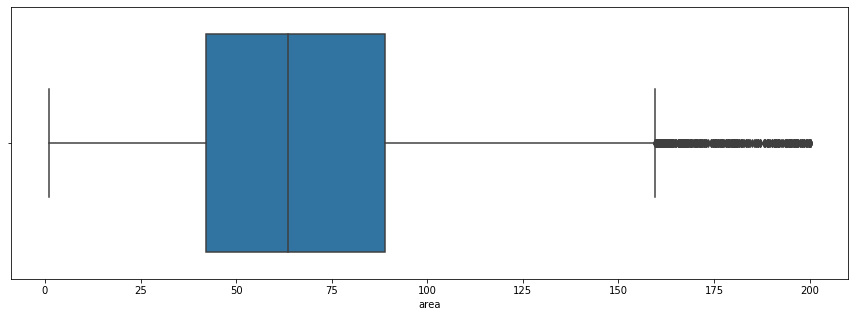

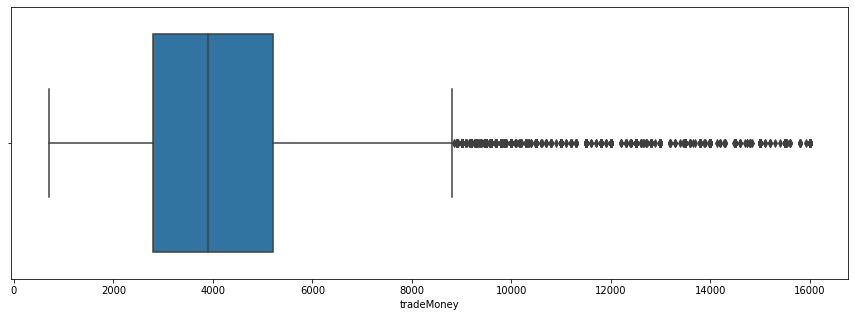

In [14]:
# 处理异常值后再次查看面积和租金分布图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

# 深度清洗

## 主要思路分析
针对每一个region的数据，对area和tradeMoney两个维度进行深度清洗。 
采用主观+数据可视化的方式。

In [15]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015')].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)

 深度清洗这部分的数值筛选不是很明白怎么确定下来的，还需要再研究研究

In [17]:
data_train.to_csv("./data/FE_Housing_train.csv", index=False, header=True)